Lorenzo Wormer, 1923031, 07.01.2021

# TMB: Exercize sheet 3

See handwritten notes for exercize 1. Notebook has to be run with Python 3.

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from enum import Enum
import pandas as pd
from functools import reduce
from itertools import product

## General concept and implementation idea

### Performance

My goal was to design this program with **performance in mind right from the beginning**, so that large MCMC simulations wouldn't be a problem. 
To that end, I tried to **avoid native python loops** as much as possible and instead rely on **numpy vector and matrix arithmetic**, which is usually way faster and can be hardware accelerated.

### State respresentation

2D configurations of proteins (chains of "H" or "P") according to the HP-model are represented within each MCMC timestep as a **list of 2D-vectors representing each amino acid's (AA) current position on the grid relative to the first AA**. The representation as relative moves along the chain (e.g. "EENNWS...") is only used for initialization of the simulation. This vector representations trades some memory for hopefully faster execution on each iteration. 

### Intersection and adjacency detection

For detecting whether a given config (list of position vectors) produces intersections and counting how many direct neighbours each AA has in that config, I first calculate a **matrix of the distances between all AAs** using the tacicab metric, then check for intersections by looking for zeros off the diagonal, and finally calculate an **adjacency-matrix** from that distance-matrix. This adjacency matrix is a symmetric sparse matrix containing a 1 for all direct neighbours and a 0 otherwise. 

### Calculation of total energy

I used the **row-wise sum on the adjacency matrix** to calculate how many direct neighbours each AA had, which in turn gave me the **count of remaining solvent spaces** per AA. I then simply **multiplied that count by the AA's binding energy** with the solvent, and finally **summed that over all AAs**.

### Generating state proposals

To generate a possible next state from the current, a **random AA is selected** within the chain (not the first one) and pivoted clockwise or counter-clockwise, meaning **all relative positions after that AA (including the AA itself) are rotated by +90° or -90°**. Additionally, it has to be checked whether this new config produces any intersections before proposing it as the next state. 

## Constants and function defintions for all exercizes

In [2]:
# Store a map of the AA type to its binding energy with solvent:
binding_energy_map = {
    "H": 2,
    "P": 1
}

# Map the move codes to 2D move vectors:
move_dict = {
    "E": (1, 0), 
    "S": (0, -1),
    "W": (-1, 0),
    "N": (0, 1)
}

In [3]:
def gen_random_chain(length):
    """
    Return a random AA chain of given length, hence a random string on the alphabet of all distinguished AA types (default 'H' and 'P').

    Parameters:
    ------
    length : int

    Returns: 
    ------
    string
    """
    return "".join((rd.choice(list(binding_energy_map.keys())) for i in range(0, length)))

In [4]:
def map_energies(chain):
    """
    Map a string of characters defining a sequence of AAs to a list of their respective solvent binding energies.

    Parameters:
    ------
    chain : string

    Returns: 
    ------
    list of int
    """
    for i, c in enumerate(chain):
        if c not in binding_energy_map: 
            raise Exception(f"Character {c} at sequence position {i} not supported")

    return np.array(list(map(lambda c: binding_energy_map[c], list(chain))))


In [5]:
def calc_positions(config):
    """
    Map a config string of characters representing n-1 relative moves to a list of n absolute positions, starting always with (0, 0).

    Parameters:
    ------
    config : string

    Returns: 
    ------
    list of 2-tuple
    """

    moves = np.array([(0, 0), *(move_dict[c] for c in config)])

    return np.cumsum(moves, axis=0)

In [6]:
def calc_adjacency_matrix(pos, check_overlap=False):
    """
    Calculate the adjacency matrix from a list of absolute positions on a 2D grid. Optionally check for intersections on the fly.

    Parameters:
    ------
    pos : list of 2-tuple with length n
    check_overlap : bool, optional

    Returns: 
    ------
    numpy array with shape (n, n)
    """

    n = len(pos)
    adj_matrix = np.zeros([n, n]) + np.diag([1]*(n-1), 1) + np.diag([1]*(n-1), -1)

    for i, r in enumerate(pos[0:-2]):
        diffs = pos[i+2:] - r
        taxicab_dists = np.sum(np.abs(diffs), axis=1)

        if check_overlap: 
            zeros = np.where(taxicab_dists < 1)
            if len(zeros[0]) != 0: 
                raise Exception(f"Overlap detected between position {str(i)} and positions {', '.join(map(str, zeros[0] + i + 2))}. Aborting.")

        taxicab_dists[taxicab_dists > 1] = 0
        adj_matrix[i, i+2:] = taxicab_dists
        adj_matrix[i+2:, i] = taxicab_dists

    return adj_matrix


In [7]:
def calc_total_energy(adj_matrix, binding_energies):
    """
    Calculate the total energy from the adjacency matrix and binding energies.

    Parameters:
    ------
    adj_matrix : numpy array with shape (n, n)
    binding_energies: list of int with length n

    Returns: 
    ------
    int
    """

    return np.sum((4 - np.sum(adj_matrix, axis=0)) * binding_energies)

## Exercize 2

In [8]:
# Represent the vertical mirroring of a NESW move sequence as a dict: 
vertical_mirror_map = {
    "N": "S",
    "E": "E", 
    "S": "N", 
    "W": "W"
}

def remove_mirror_symmetries(configs):
    """
    Remove all mirror symmetries from a list of config strings (strings of NESW moves) and return as new list. 

    Parameters:
    ------
    configs: list of strings

    Returns: 
    ------
    list of strings
    """

    pure_configs = set(configs)

    for conf in configs:
        if conf not in pure_configs: continue
        
        conf_mirrored = "".join([vertical_mirror_map[c] for c in conf])
        pure_configs.remove(conf_mirrored)

    return list(pure_configs)

In [9]:
compact_configs_16 = remove_mirror_symmetries(pd.read_csv("./compact016.dat", header=None)[0].to_numpy())
# The original list still contains mirror symmetries (strings where all N and S are switched).
# As these will always produce a degenerate ground state, they have to be removed.

In [10]:
def gen_unique_ground_state_16():
    """
    Perform the search for a unique ground state with chain length 16. 
    Do this by randomly generating AA sequences and testing all their compact configurations for a unique energy minimum until one is found. 

    Returns: 
    ------
    dict
        contains the chain (HP-sequence), the config (NESW-sequence), as well as the energy and diameter of the ground state
    """
    
    ground_state = None

    for i in range(0, 1000):
        chain = gen_random_chain(16)
        energies = map_energies(chain)

        all_total_E = np.array(
            [
                calc_total_energy(
                    calc_adjacency_matrix(
                        calc_positions(conf)
                    ), 
                    energies
                ) 
                for conf in compact_configs_16
            ]
        )

        min_indices = np.where(all_total_E == np.amin(all_total_E))[0]

        if len(min_indices) == 1:
            config = compact_configs_16[min_indices[0]]
            pos = calc_positions(config)
            diam = np.linalg.norm(pos[-1] - pos[0])
            E_tot = all_total_E[min_indices[0]]

            ground_state = {
                "chain": chain, 
                "config": config, 
                "diam": diam, 
                "E_tot": E_tot
            }
            break

    return ground_state

In [11]:
unique_folded_state = gen_unique_ground_state_16()

unique_folded_state

{'chain': 'PPPHHHHPHHHPPHPP',
 'config': 'EENWWNNESENESSS',
 'diam': 3.0,
 'E_tot': 20.0}

In [12]:
# Use nicest one:
unique_folded_state = {
    'chain': 'PHHHPHHHHPHPHPHP',
    'config': 'ENWNEESSENNNWWW',
    'diam': 3.0,
    'E_tot': 23.0
}

## Preparation for exercizes 3 and 4

In [13]:
def pivot_config_at_index(pos, adj_matrix, index, direction="counter-clockwise"):
    """
    Perform a pivot around the specified index on a 2D-configuration represented by a list of positions and the associated adjacency matrix. 
    Pivot means a 90° rotation of every position [index:] around the position at [index - 1]. 
    Rotates counter-clockwise unless specified otherwise. 
    Updates the adjacency matrix alongside the positions in an efficient manner.

    Parameters:
    ------
    pos : list of 2-tuple with length n
        The current absolute positions of all AAs
    adj_matrix : numpy array with shape (n, n)
        The adjacency matrix for the current positions
    index: int
        index to pivot around
    direction: string
        direction to pivot in ("clockwise" or "counter-clockwise")

    Returns: 
    ------
    list of 2-tuple with length n
        The new absolute positions of all AAs, with a pivot performed at the specified index
    numpy array with shape (n, n)
        The adjacency matrix for the new positions

    Raises: 
    ------
    Exception
        If the new config produces an 
    """

    const_pos = pos[:index]

    rotated_pos = np.matmul(
            pos[index:] - pos[index - 1],
            np.array([[0, 1], [-1, 0]]) * (-1 if direction == "clockwise" else 1)
        ) + pos[index - 1]

    new_pos = np.concatenate([const_pos, rotated_pos], axis=0)

    if len(rotated_pos) > 0 and np.array_equal(const_pos[-1], rotated_pos[0]): 
        raise Exception("intersection directly at pivot")
    
    matrix_update = np.sum(
        list(
            map(
                lambda x: np.abs(np.subtract.outer(*x)), 
                (
                    (const_pos[:, i], rotated_pos[:, i]) for i in range(0, 2)
                )
            )
        ), 
        axis=0
    )

    zeros = np.where(matrix_update < 1)
    if len(zeros[0]) != 0: 
        raise Exception(f"Overlaps at {', '.join(map(lambda x: f'({x[0]}, {x[1]})', zeros))}")


    matrix_update[matrix_update > 1] = 0

    new_matrix = np.copy(adj_matrix)
    new_matrix[:index, index:] = matrix_update
    new_matrix[-index:, :-index] = matrix_update

    return new_pos, new_matrix

In [14]:
def propose_next_state(pos, adj_matrix):
    """
    Propose a possible next state by randomly selecting an index to pivot around and performing that pivot until it succeeds (doesn't produce overlap).

    Parameters:
    ------
    pos : list of 2-tuple with length n
        The current absolute positions of all AAs
    adj_matrix : numpy array with shape (n, n)
        The adjacency matrix for the current positions

    Returns: 
    ------
    list of 2-tuple with length n
        The new absolute positions of all AAs, with a pivot performed at the specified index
    numpy array with shape (n, n)
        The adjacency matrix for the new positions
    """
    
    next_state = None

    while(next_state is None):
        rand_index = rd.choice(range(1, len(pos)))
        try:
            next_state = pivot_config_at_index(
                pos, 
                adj_matrix, 
                rand_index,
                direction=rd.choice(["clockwise", "counter-clockwise"])
            )
        except:
            continue

    return next_state

In [15]:
def calc_transition_probability(delta_E, T):
    """
    Calculate the transition probability to a new state given the energy difference to that state and the current temperature T.

    Parameters:
    ------
    delta_E : int
    T: float

    Returns: 
    ------
    float
    """

    return np.exp(- 1 / T * delta_E)

In [16]:
def MCMC_timestep(pos, adj_matrix, E_tot, T, binding_energies):
    """
    Perform an MCMC timestep by proposing a new state and accepting or rejecting it according to its transition probability. 

    Parameters:
    ------
    pos : list of 2-tuple with length n
        The current absolute positions of all AAs
    adj_matrix : numpy array with shape (n, n)
        The adjacency matrix for the current positions
    E_tot : int
        The current config's total energy
    T : float
        Current temperature
    binding_energies : list of int
        Binding energies for the AA sequence on which the MCMC is run
    
    Returns: 
    ------
    float
    """

    pos_new, adj_matrix_new = propose_next_state(pos, adj_matrix)

    E_tot_new = calc_total_energy(adj_matrix_new, binding_energies)
    trans_prob = calc_transition_probability(E_tot_new - E_tot, T)

    return (pos_new, adj_matrix_new, E_tot_new) if rd.random() < trans_prob else (pos, adj_matrix, E_tot)

In [17]:
def run_MCMC(chain, initial_config, T_profile, break_condition=None, n=1000):
    """
    Run the MCMC with given parameters

    Parameters:
    ------
    chain : string
        Chain of AAs to run on
    initial_config : string
        The initial 2D-config given by a string of NESW moves
    T_profile : function
        A function returning the current temperature for given timestep index i and total number of timesteps n
    break_condition : function, optional
        A function receiving the list of all recorded state metrics on each iteration and returning a boolean, which stops the simulation if true
    n : int, optional
        The (maximum) number of iterations to run
    Returns: 
    ------
    list of tuple
        list of recorded state metrics for all timesteps
    """

    energies = map_energies(chain)

    pos = calc_positions(initial_config)
    adj_matrix = calc_adjacency_matrix(pos)
    E_tot = calc_total_energy(adj_matrix, energies)

    trace = [
        (np.linalg.norm(pos[-1] - pos[0]), np.sum(adj_matrix), E_tot, T_profile(0, n))
    ]

    for i in range(1, n):
        T = T_profile(i, n)

        pos, adj_matrix, E_tot = MCMC_timestep(pos, adj_matrix, E_tot, T, energies)
        trace.append(
            (np.linalg.norm(pos[-1] - pos[0]), np.sum(adj_matrix), E_tot, T)
        )

        if break_condition is not None and break_condition(trace):
            break

    return pd.DataFrame.from_records(trace, columns=["diameter", "adjacency_sum", "total_energy", "T"])

In [18]:
def gen_linear_T_profile(T_start, T_end):
    """
    Generate a linear temperature profile function from a given start and end temperature. 
    To be used in conjuction with run_MCMC()

    Parameters:
    ------
    T_start, T_end: float
    Returns: 
    ------
    function
    """

    return lambda i, n: T_start + (T_end - T_start) / n * i

## Exercize 3

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

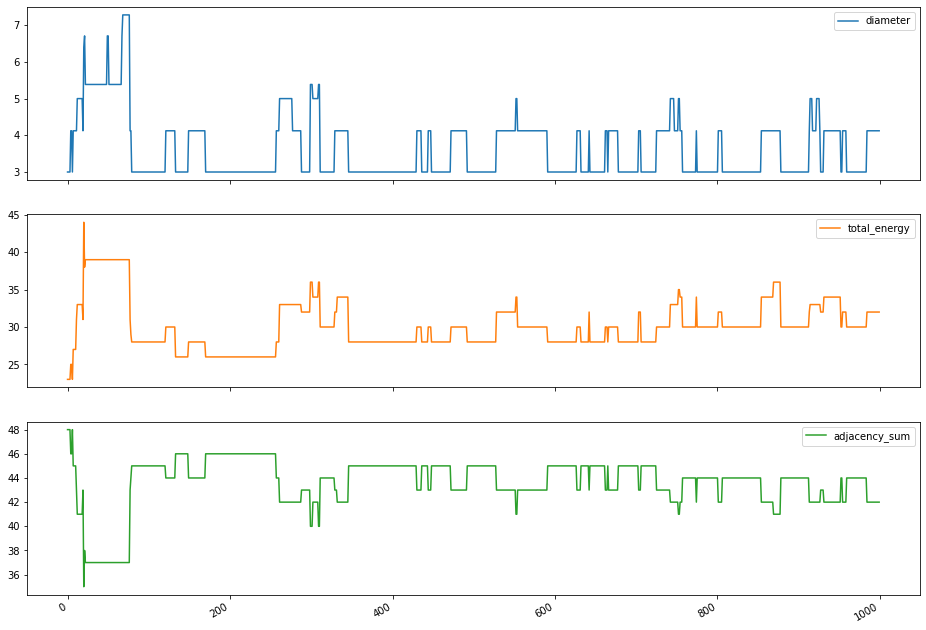

In [19]:
# Start single MCMC from compact state:
unfolding_trace = run_MCMC(unique_folded_state["chain"], unique_folded_state["config"], lambda i, n: 2)
unfolding_trace[["diameter", "total_energy", "adjacency_sum"]].plot(figsize=(16, 12), subplots=True)

In [20]:
def sample_unfolding_on_T_interval(threshold_factor=1.25, T_min=0.8, T_max=2.4, resolution=9, replications=20, max_iterations=10000):
    """
    Generate a mean unfolding time (with standard deviation) for a set of temperatures via sampling many MCMC simulations. 

    Parameters:
    ------
    threshold_factor : float, optional
        Factor, by which the diameter has to increase from the compact state to consider a config unfolded
    T_min, T_max : float, optional
        Define the temperature interval to look at
    resolution: int, optional
        Number of distinct temperatures to sample within the interval
    replications : int, optional
        Size of the sample for each temperature
    max_iterations : int, optional
        The maximum number of iterations to run on each simulation
    Returns: 
    ------
    dataframe
        mean unfolding time with std for each temperature
    """

    def calc_unfolding_stats_at_T(T):
        sample = np.array([
            len(
                run_MCMC(
                    unique_folded_state["chain"], 
                    unique_folded_state["config"], 
                    lambda i, n: T, 
                    break_condition=lambda trace: trace[-1][0] > threshold_factor * trace[0][0], 
                    n=max_iterations
                ).index
            )
            for i in range(0, replications)
        ])

        sample = sample[sample != max_iterations]

        return (
            T, 
            np.mean(sample), 
            np.std(sample)
        ) if len(sample) > 0 else None
    
    data = [
        calc_unfolding_stats_at_T(T)
        for T in np.linspace(T_min, T_max, resolution) 
    ]

    df = pd.DataFrame.from_records(data, columns=["T", "mean_unfolding_time", "unfolding_time_std"])
    return df.loc[df["mean_unfolding_time"] != max_iterations]


<AxesSubplot:xlabel='T', ylabel='mean_unfolding_time'>

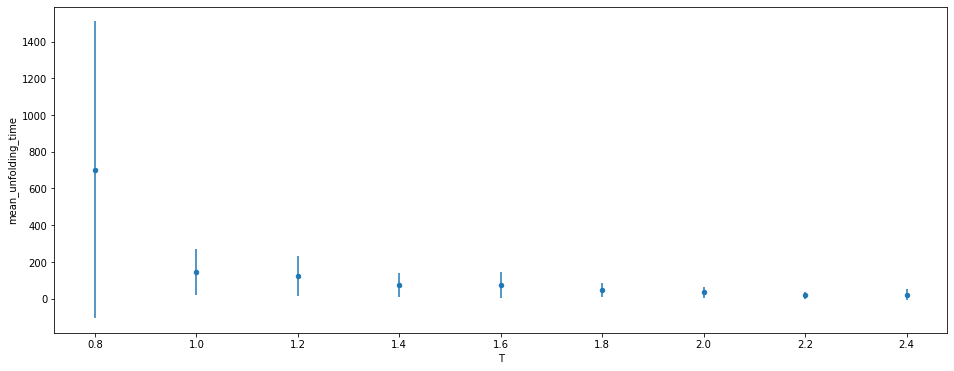

In [21]:
# Run with default parameters to get an overview: 
T_dependence = sample_unfolding_on_T_interval()
T_dependence.plot(figsize=(16, 6), kind="scatter", x="T", y="mean_unfolding_time", yerr="unfolding_time_std")

<AxesSubplot:xlabel='T', ylabel='mean_unfolding_time'>

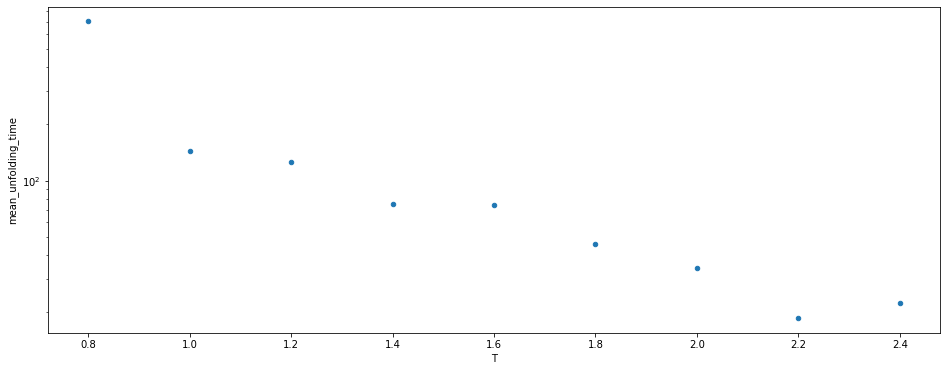

In [22]:
# Plot additionally with logarithmic y axis: 
T_dependence.plot(figsize=(16, 6), kind="scatter", x="T", y="mean_unfolding_time", logy=True)

<AxesSubplot:xlabel='T', ylabel='mean_unfolding_time'>

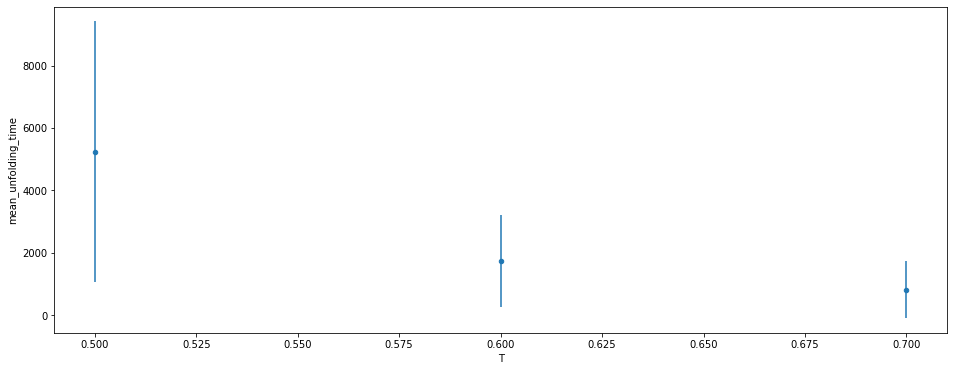

In [23]:
# Sample colder temperatures with adapted parameters: 
cold_T_dependence = sample_unfolding_on_T_interval(T_min=0.5, T_max=0.7, resolution=3, replications=5, max_iterations=100000)
cold_T_dependence.plot(figsize=(16, 6), kind="scatter", x="T", y="mean_unfolding_time", yerr="unfolding_time_std")

<AxesSubplot:xlabel='T', ylabel='mean_unfolding_time'>

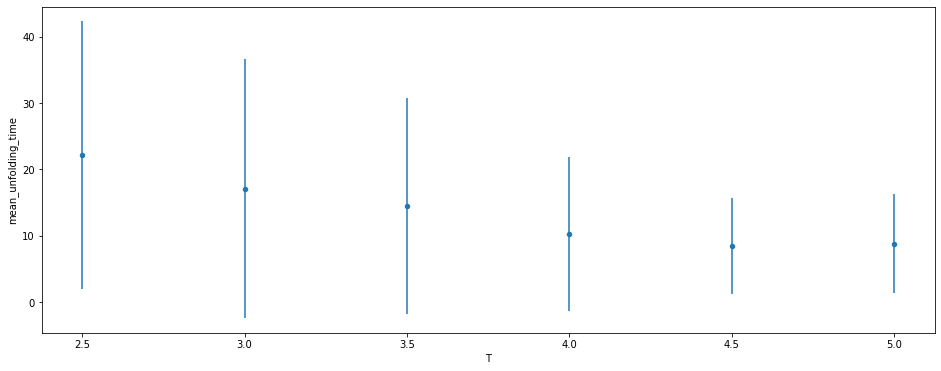

In [24]:
# Sample hotter temperatures with adapted parameters: 
hot_T_dependence = sample_unfolding_on_T_interval(T_min=2.5, T_max=5, resolution=6, replications=100)
hot_T_dependence.plot(figsize=(16, 6), kind="scatter", x="T", y="mean_unfolding_time", yerr="unfolding_time_std")

## Exercize 4

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

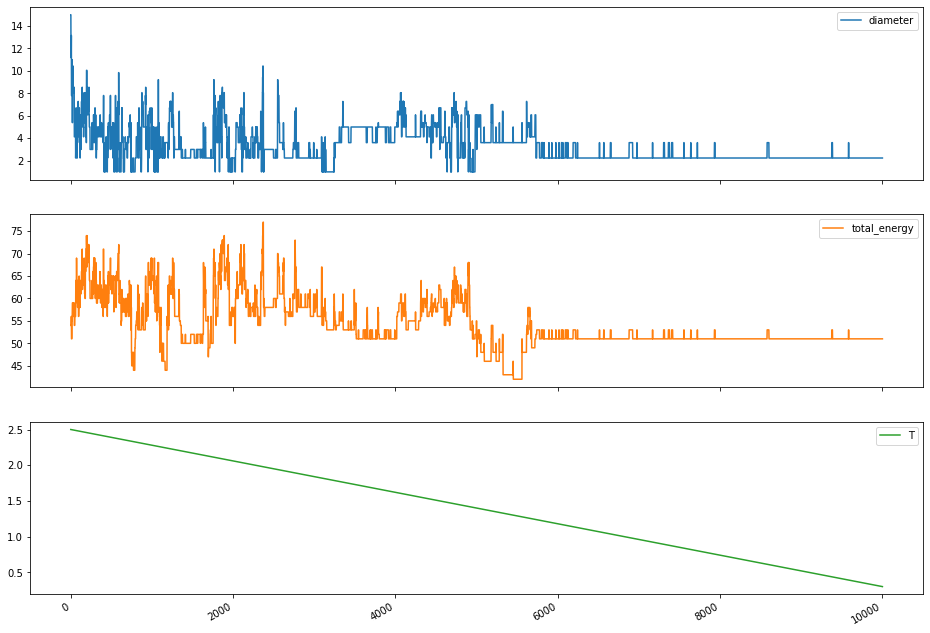

In [25]:
# Start from a completely unfolded state at a high temperature and decrease temperature with a linear profile: 
folding_trace = run_MCMC(unique_folded_state["chain"], "E"*15, gen_linear_T_profile(2.5, 0.3), n=10000)
folding_trace[["diameter", "total_energy", "T"]].plot(figsize=(16, 12), subplots=True)